In [257]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

<h1> Problem 1.2 and 1.3 code and ploting </h1>

In [258]:
# generate data
np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
+ 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

Populating the interactive namespace from numpy and matplotlib


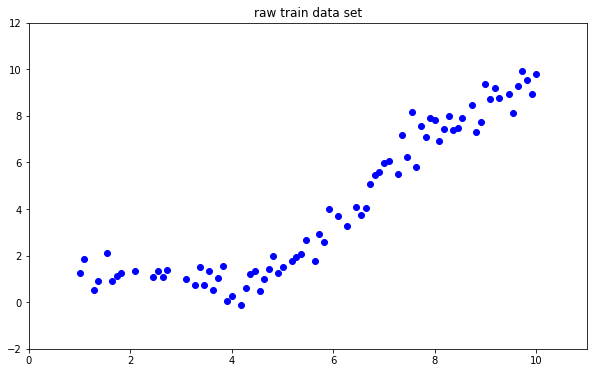

In [259]:
#plot of trainData
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

plt.plot(trainData, trainTarget, 'bo')
plt.axis([0,11, -2, 12])
plt.title("raw train data set")
plt.show()

In [260]:
def pairwise_dist(x, z):
    z = tf.transpose(z)
    return tf.squared_difference(x, z)

In [261]:
#testing pairwise_dist function
x = tf.constant([[1],[2],[3],[4]])
z = tf.constant([[1],[2],[3]])
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
print(sess.run(pairwise_dist(x,z)))

[[0 1 4]
 [1 0 1]
 [4 1 0]
 [9 4 1]]


In [262]:
def get_respon_mat(m, k):
    #m = tf.transpose(m)
    # get sorted index
    values, indices = tf.nn.top_k(-m, k, sorted=True)
    #indices, dummy = tf.nn.top_k(-indices, k, sorted=True)
    #indices = -indices
    # build up [[1,2], [1,3]] index form
    indices_pair = tf.tile(tf.reshape(tf.range(0, tf.shape(m)[0]), [-1,1]), [1,k])
    concated = tf.concat(2, [tf.reshape(indices_pair, [-1,k,1]), tf.reshape(indices, [-1,k,1])])
    concated = tf.reshape(concated, [-1,2])
    # return dense matrix
    value = 1 / k
    res = tf.sparse_to_dense(sparse_indices=concated, output_shape=[tf.shape(m)[0], tf.shape(m)[1]], \
                               sparse_values=value, validate_indices=False)
    return res

In [263]:
# testing for get_respon_mat function
train = tf.placeholder(tf.float32)
X = tf.placeholder(tf.float32)
target = tf.placeholder(tf.float32)
test_input = np.linspace(0.0, 11.0, num = 1000)
test_input = np.expand_dims(test_input, axis=0)
test_input = np.transpose(test_input)
r = get_respon_mat(pairwise_dist(X, train), 2)
y_hat = tf.matmul(tf.transpose(target), tf.transpose(r))
sess.run(init)
predict = sess.run(y_hat, feed_dict={X: test_input, train: trainData, target: trainTarget})

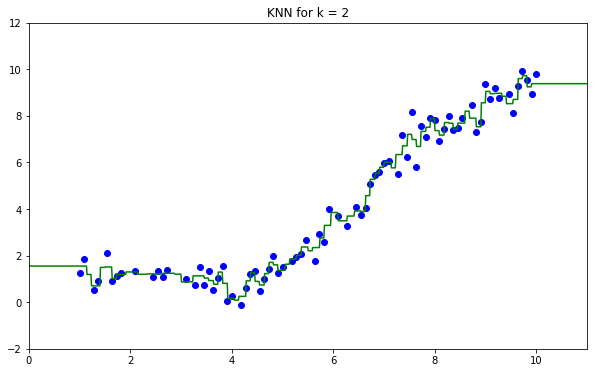

In [264]:
plt.plot(trainData, trainTarget, 'bo', test_input, np.transpose(predict), 'g-')
plt.axis([0,11, -2, 12])
plt.title("KNN for k = 2")
plt.show()

k:  1, trainMSE: 0.00, validMSE: 5.43, testMSE: 6.22


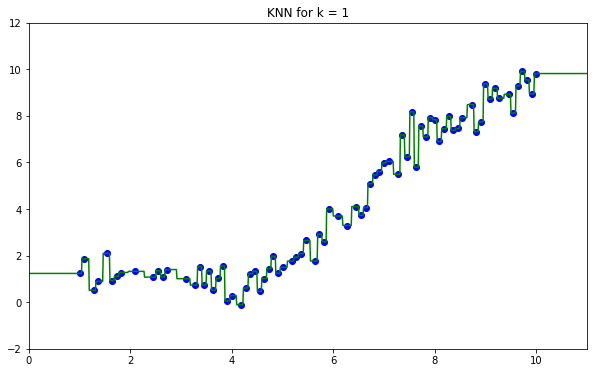

k:  3, trainMSE: 16.84, validMSE: 6.53, testMSE: 2.90


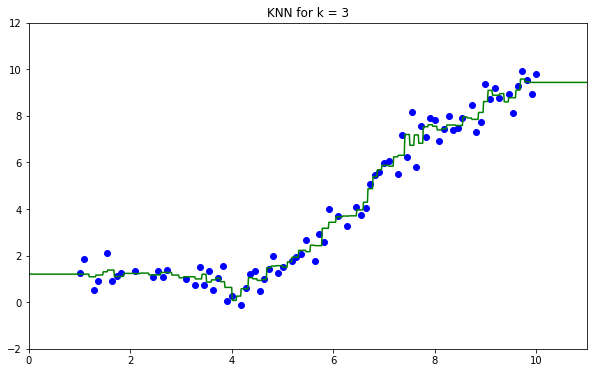

k:  5, trainMSE: 18.97, validMSE: 6.21, testMSE: 3.57


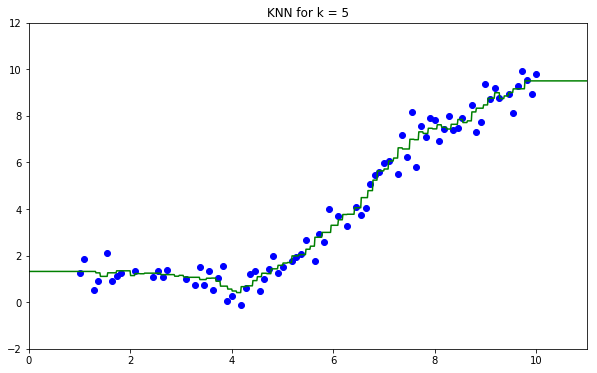

k: 50, trainMSE: 199.68, validMSE: 24.57, testMSE: 14.14


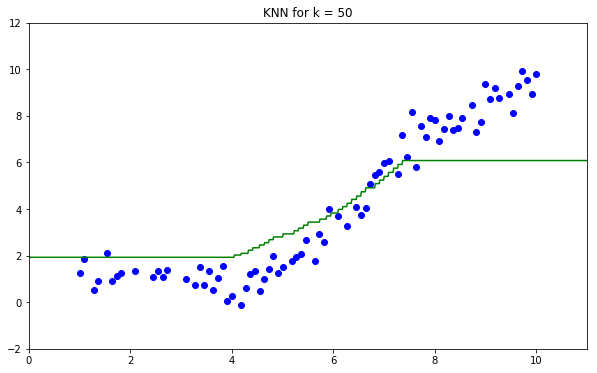

Best k value based on validation err is: 1


In [265]:
# train model
kList = [1,3,5,50]
train = tf.placeholder(tf.float32)
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)
target = tf.placeholder(tf.float32)
test_input = np.linspace(0.0, 11.0, num = 1000)
test_input = np.expand_dims(test_input, axis=0)
test_input = np.transpose(test_input)
plot_input = tf.constant(test_input)
best_k = 0
min_err = float("inf")
sess.run(init)
for k in kList:
    # Error definition
    r = get_respon_mat(pairwise_dist(X, train), k)
    y_hat = tf.matmul(tf.transpose(target), tf.transpose(r))
    meanSquaredError = tf.reduce_mean(tf.reduce_sum(tf.square(y_hat - tf.transpose(Y)), reduction_indices=[1]))
    trainMSE = sess.run(meanSquaredError, feed_dict={X: trainData, Y: trainTarget, train: trainData, target: trainTarget})
    validMSE = sess.run(meanSquaredError, feed_dict={X: validData, Y: validTarget, train: trainData, target: trainTarget})
    testMSE = sess.run(meanSquaredError, feed_dict={X: testData, Y: testTarget, train: trainData, target: trainTarget})
    plot_predict = sess.run(y_hat, feed_dict={X: test_input, train: trainData, target: trainTarget})
    if validMSE < min_err:
        min_err = validMSE
        best_k = k
    print("k: %2d, trainMSE: %0.2f, validMSE: %0.2f, testMSE: %0.2f"%(k, trainMSE, validMSE, testMSE))
    plt.plot(trainData, trainTarget, 'bo', test_input, np.transpose(plot_predict), 'g-')
    plt.axis([0,11, -2, 12])
    plt.title("KNN for k = %d"%(k))
    plt.show()
print("Best k value based on validation err is: %d"%(best_k))

<h1>Problem2 coding</h1>

In [266]:
with np.load ("../data/tinymnist.npz") as data :
        trainData, trainTarget = data ["x"], data["y"]
        validData, validTarget = data ["x_valid"], data ["y_valid"]
        testData, testTarget = data ["x_test"], data ["y_test"]

In [267]:
def buildGraph(decay_rate, learning_rate):
    # Variable creation
    W = tf.Variable(tf.truncated_normal(shape=[64,1], stddev=0.5), name='weights')
    b = tf.Variable(0.0, name='biases')
    X = tf.placeholder(tf.float32, [None, 64], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,1], name='target_y')

    # Graph definition
    y_predicted = tf.matmul(X,W) + b

    # Error definition
    error =  0.5 * tf.reduce_mean(tf.reduce_sum(tf.square(y_predicted - y_target), 
                                                reduction_indices=1, 
                                                name='squared_error'), 
                                  name='mean_squared_error') + \
             0.5 * decay_rate * tf.reduce_sum(tf.square(W))

    # Training mechanism
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return W, b, X, y_target, y_predicted, error, train

def getRandomBatch(trainData, trainTarget, size):
    idx = np.random.choice(trainData.shape[0], size, replace=False)
    return trainData[idx,:], trainTarget[idx,:]

In [277]:

W, b, X, y_target, y_predicted, error, train = buildGraph(0.1, 0.1)
loss, _ = sess.run([error, train], feed_dict={X: trainData, y_target: trainTarget})
print(loss)

1.34173


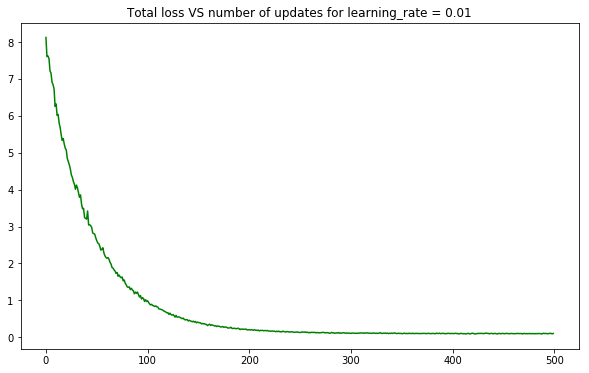

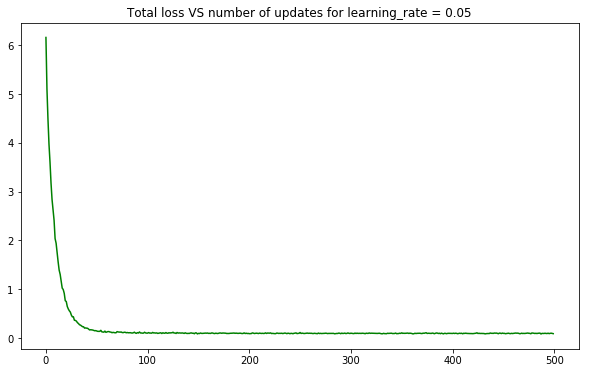

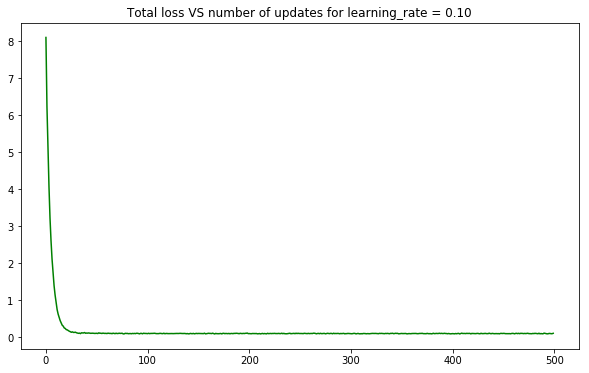

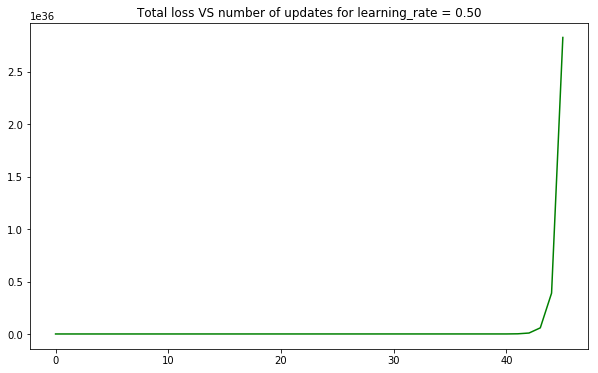

In [293]:
#2.1 fix decay_rate = 1 and tune learning_rate
decay_rate = 1
batch_size = 50
learning_rate_list = [0.01, 0.05, 0.1, 0.5]
for learning_rate in learning_rate_list: 
    W, b, X, y_target, y_predicted, error, train = buildGraph(decay_rate, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    for itr in range(500):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        loss, _ = sess.run([error, train], feed_dict={X: batch_xs, y_target: batch_ys})
        loss_recorder = np.append(loss_recorder, loss)
    plt.plot(np.arange(500), loss_recorder, 'g')
    #plt.axis([0,2000, 0, 2])
    plt.title("Total loss VS number of updates for learning_rate = %0.2f"%(learning_rate))
    plt.show()
        

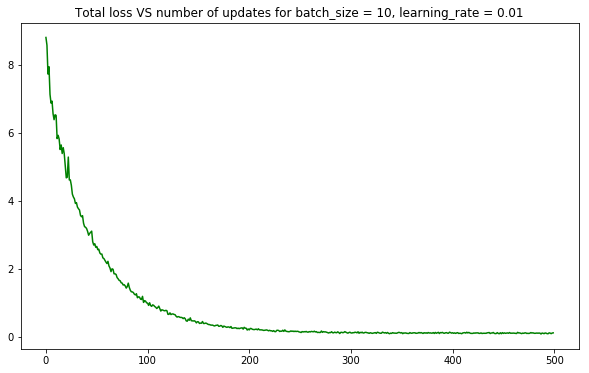

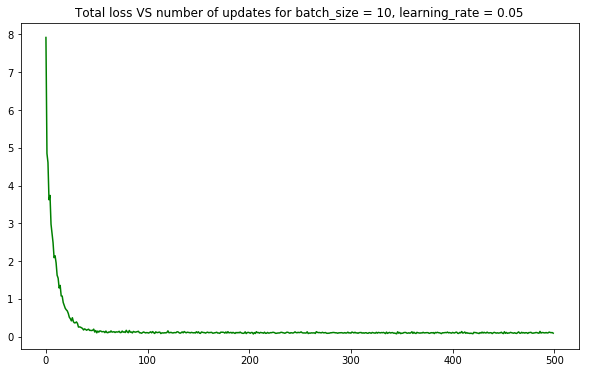

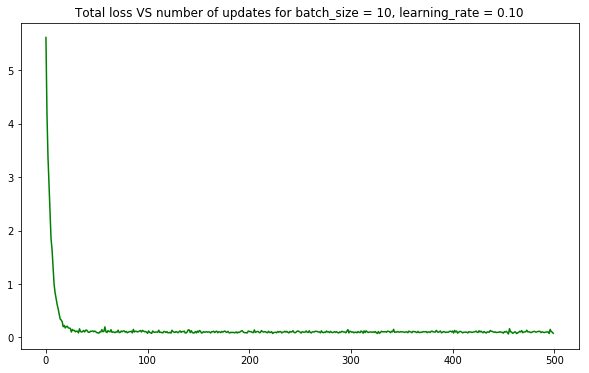

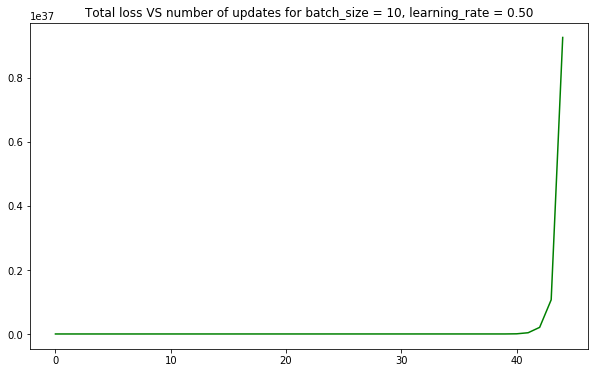

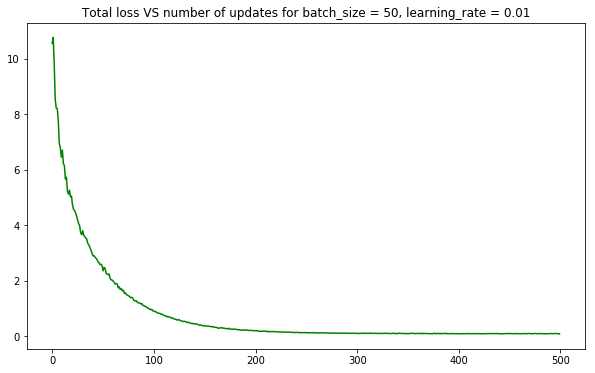

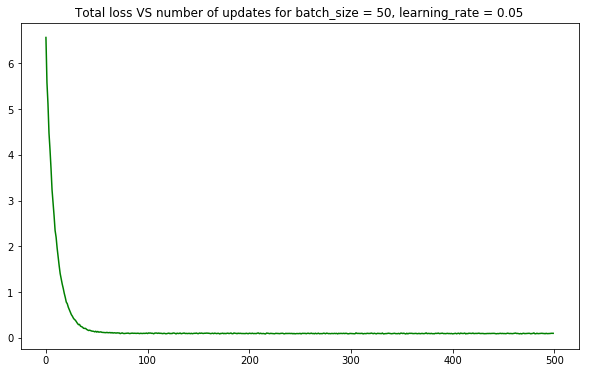

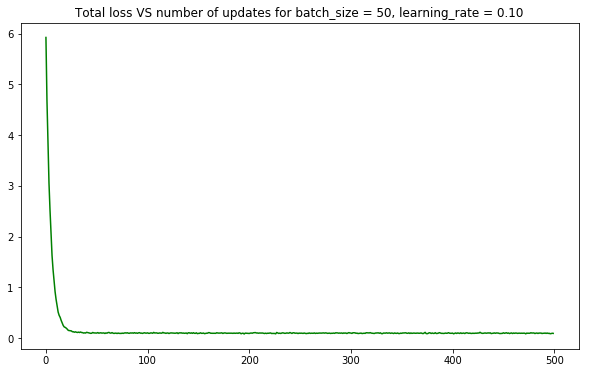

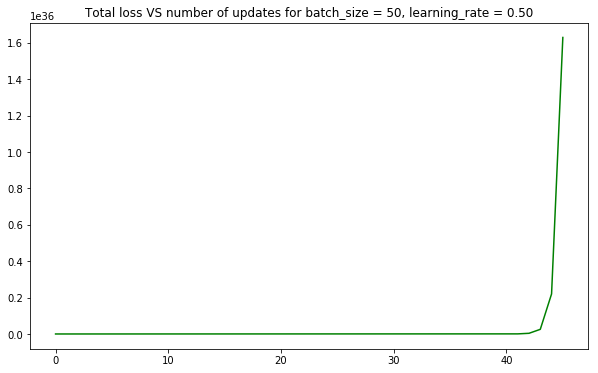

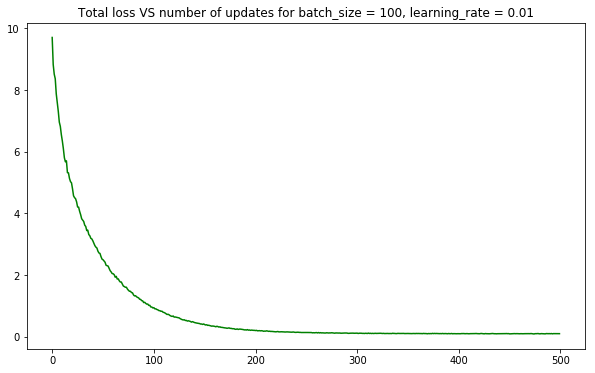

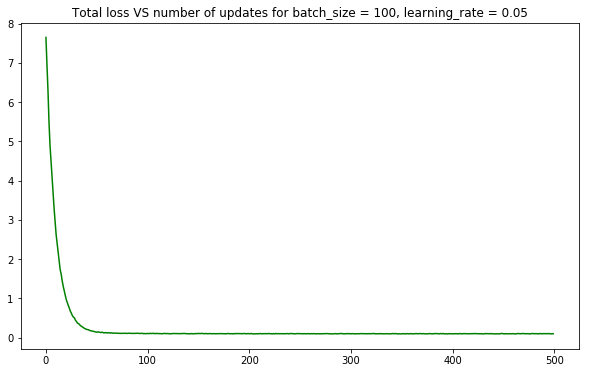

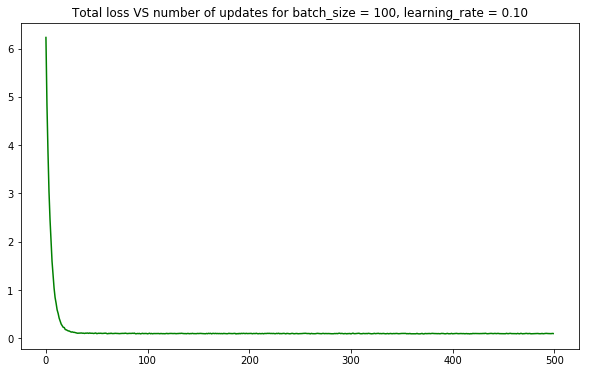

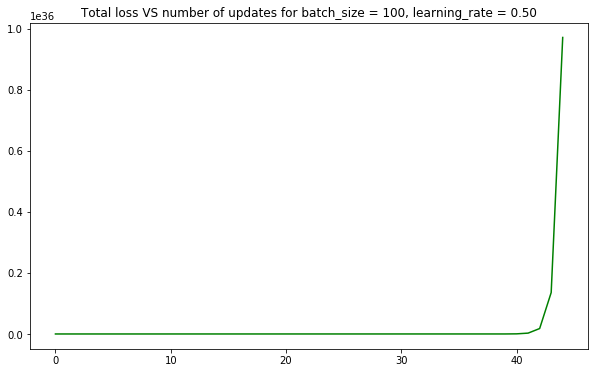

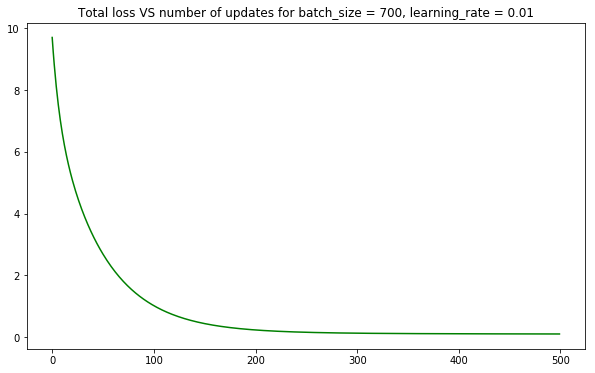

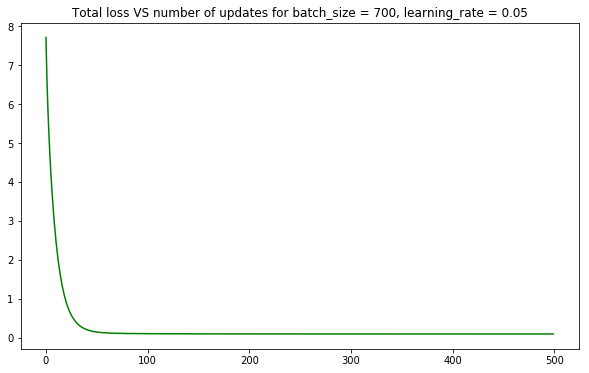

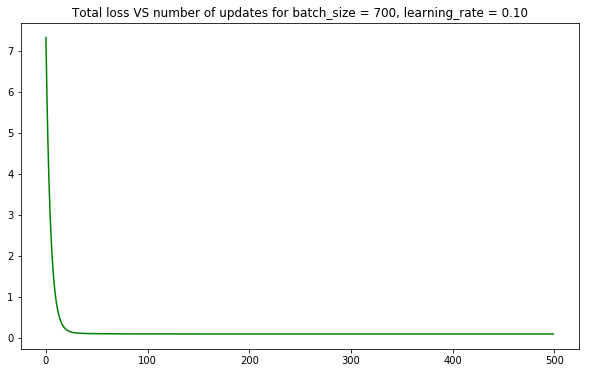

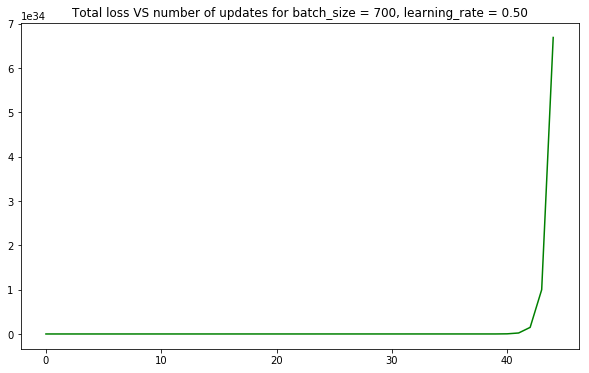

In [295]:
#2.2 fix decay_rate = 1 and tune learning_rate and batch_size
decay_rate = 1
batch_size_list = [10,50,100,700]
learning_rate_list = [0.01, 0.05, 0.1, 0.5]
for batch_size in batch_size_list:
    for learning_rate in learning_rate_list: 
        W, b, X, y_target, y_predicted, error, train = buildGraph(decay_rate, learning_rate)
        init = tf.global_variables_initializer()
        sess = tf.InteractiveSession()
        sess.run(init)
        loss_recorder = np.array([])
        for itr in range(500):
            batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
            loss, _ = sess.run([error, train], feed_dict={X: batch_xs, y_target: batch_ys})
            loss_recorder = np.append(loss_recorder, loss)
        plt.plot(np.arange(500), loss_recorder, 'g')
        #plt.axis([0,2000, 0, 2])
        plt.title("Total loss VS number of updates for batch_size = %d, learning_rate = %0.2f"%(batch_size, learning_rate))
        plt.show()

In [ ]:
#2.3 fix batch_size = 50 and learning_rate = 0.5 and tune decay_rate
decay_rate_list = [0., 0.0001, 0.001, 0.01, 0.1, 1.]
batch_size = 50
learning_rate = 0.5
best_decay_rate = 0
best_acc = 0
test_acc_recorder = np.array([])
for decay_rate in decay_rate_list:
    W, b, X, y_target, y_predicted, error, train = buildGraph(decay_rate, learning_rate)
    correct_prediction = tf.equal(y_target, (tf.sign(y_predicted - 0.5) + 1) / 2)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    for itr in range(500):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        sess.run(train, feed_dict={X: batch_xs, y_target: batch_ys})
    # use valid data set accuracy to tune decay rate
    cur_acc = sess.run(accuracy, feed_dict={X: validData, y_target: validTarget})
    print(cur_acc, decay_rate)
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_decay_rate = decay_rate
    # use test set to test accuracy
    #test_acc_recorder = np.append(test_acc_recorder, sess.run(accuracy, \
    #                                                          feed_dict={X: testData, y_target: testTarget}))
print("Best accuracy in valid set is: %0.2f"%(best_acc))
plt.plot(decay_rate_list, test_acc_recorder, 'go')
#plt.axis([0,2000, 0, 2])
plt.title("Accuracy VS decay_rate for batch_size = 50, learning_rate = 0.5")
plt.show()

In [299]:
print(trainTarget)

[[ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]